In [ ]:
# ✅ Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 1: Import Libraries and Setup
# ================================
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

# ================================
# Cell 2: Configuration
# ================================
# Defect classes for binary classification
DEFECT_TYPES = ['open', 'short', 'mousebite', 'spur', 'copper', 'pin-hole']
NUM_DEFECT_TYPES = len(DEFECT_TYPES)

# Data paths
TRAIN_LABEL_CSV = "/content/drive/MyDrive/Colab Notebooks/DL/trainval_label.csv"
TEST_LABEL_CSV  = "/content/drive/MyDrive/Colab Notebooks/DL/test_label.csv"
TRAIN_IMG_DIR   = "/content/drive/MyDrive/Colab Notebooks/DL/train"
TEST_IMG_DIR    = "/content/drive/MyDrive/Colab Notebooks/DL/test"

# Training parameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 15

print(f"Defect types: {DEFECT_TYPES}")
print(f"Will create {NUM_DEFECT_TYPES} binary classifiers")


Libraries imported successfully!
Defect types: ['open', 'short', 'mousebite', 'spur', 'copper', 'pin-hole']
Will create 6 binary classifiers


In [ ]:
# Cell 3: Data Loading for Binary Classification
# ================================
def load_binary_classification_data():
    """Load data for binary classification approach"""
    print("Loading data for binary classification...")

    # Load training data
    df = pd.read_csv(TRAIN_LABEL_CSV)
    df = df[df['filename'].str.contains('_temp.jpg|_test.jpg', na=False)]

    # Load test data
    test_df = pd.read_csv(TEST_LABEL_CSV)
    test_df = test_df[test_df['filename'].str.contains('_temp.jpg|_test.jpg', na=False)]

    print(f"Training samples: {len(df)}")
    print(f"Test samples: {len(test_df)}")

    # Create binary labels for each defect type
    binary_datasets = {}

    for defect_type in DEFECT_TYPES:
        print(f"\n=== Creating binary dataset for '{defect_type}' ===")

        # Training data
        train_binary_df = df.copy()
        train_binary_df['has_defect'] = (train_binary_df[defect_type] > 0).astype(int)

        # Test data
        test_binary_df = test_df.copy()
        test_binary_df['has_defect'] = (test_binary_df[defect_type] > 0).astype(int)

        # Check distribution
        train_pos = train_binary_df['has_defect'].sum()
        train_neg = len(train_binary_df) - train_pos
        test_pos = test_binary_df['has_defect'].sum()
        test_neg = len(test_binary_df) - test_pos

        print(f"Training: Positive={train_pos:3d}, Negative={train_neg:3d} (ratio: 1:{train_neg/max(train_pos,1):.1f})")
        print(f"Test:     Positive={test_pos:3d}, Negative={test_neg:3d} (ratio: 1:{test_neg/max(test_pos,1):.1f})")

        # Train/validation split
        if train_pos > 1:  # Only if we have enough positive samples
            train_df_split, val_df_split = train_test_split(
                train_binary_df, test_size=0.2, stratify=train_binary_df['has_defect'], random_state=42
            )
        else:
            # If too few positive samples, use random split
            train_df_split, val_df_split = train_test_split(
                train_binary_df, test_size=0.2, random_state=42
            )

        binary_datasets[defect_type] = {
            'train': train_df_split.reset_index(drop=True),
            'val': val_df_split.reset_index(drop=True),
            'test': test_binary_df.reset_index(drop=True)
        }

    return binary_datasets

In [ ]:
# Cell 4: Data Transforms and Dataset Class
# ================================
# Data transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class BinaryDefectDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Image loading error: {img_path}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        label = int(row['has_defect'])

        if self.transform:
            image = self.transform(image)

        return image, label

print("Binary dataset class defined!")


Binary dataset class defined!


In [ ]:
# Cell 5: Binary CNN Model
# ================================
class BinaryCNN(nn.Module):
    """Binary classifier for individual defect types"""
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),

            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),

            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # Binary classification
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze()

print("Binary CNN model defined!")

Binary CNN model defined!


In [ ]:
# Cell 6: Training Function for Binary Model
# ================================
def train_binary_model(model, train_loader, val_loader, defect_type, device, epochs=15):
    """Train individual binary classifier"""
    model.to(device)

    # Calculate class weights
    pos_weight = None
    if len(train_loader.dataset) > 0:
        labels = [train_loader.dataset[i][1] for i in range(len(train_loader.dataset))]
        pos_count = sum(labels)
        neg_count = len(labels) - pos_count
        if pos_count > 0:
            pos_weight = torch.tensor([neg_count / pos_count]).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    print(f"\n🚀 Training binary classifier for '{defect_type}'")
    print("-" * 60)

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = (outputs > 0.5).float()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                preds = (outputs > 0.5).float()
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels)

        val_loss_epoch = val_loss / len(val_loader.dataset)
        val_acc_epoch = val_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss_epoch)
        val_accs.append(val_acc_epoch.item())

        scheduler.step(val_loss_epoch)

        if val_acc_epoch > best_val_acc:
            best_val_acc = val_acc_epoch
            torch.save(model.state_dict(), f'best_{defect_type}_model.pth')

        if epoch % 3 == 0 or epoch == epochs - 1:
            print(f'Epoch [{epoch+1:2d}/{epochs}] Train: {epoch_acc:.3f} | Val: {val_acc_epoch:.3f} | Best: {best_val_acc:.3f}')

    print(f"✅ Training completed for '{defect_type}' - Best Val Acc: {best_val_acc:.3f}")
    return model, train_losses, val_losses, train_accs, val_accs


In [ ]:
# Cell 7: Multi-Binary Ensemble Class
# ================================
class MultiBinaryEnsemble:
    """Ensemble of binary classifiers"""
    def __init__(self, defect_types, device):
        self.defect_types = defect_types
        self.device = device
        self.models = {}

    def train_all_models(self, binary_datasets, epochs=15):
        """Train all binary classifiers"""
        self.training_histories = {}

        for defect_type in self.defect_types:
            print(f"\n{'='*50}")
            print(f"Training classifier for: {defect_type.upper()}")
            print(f"{'='*50}")

            # Create dataloaders
            train_dataset = BinaryDefectDataset(
                binary_datasets[defect_type]['train'], TRAIN_IMG_DIR, transform_train
            )
            val_dataset = BinaryDefectDataset(
                binary_datasets[defect_type]['val'], TRAIN_IMG_DIR, transform_val_test
            )

            # Skip if no positive samples
            train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
            if sum(train_labels) == 0:
                print(f"⚠️  Skipping '{defect_type}' - No positive samples in training data")
                continue

            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

            # Train model
            model = BinaryCNN()
            model, train_loss, val_loss, train_acc, val_acc = train_binary_model(
                model, train_loader, val_loader, defect_type, self.device, epochs
            )

            self.models[defect_type] = model
            self.training_histories[defect_type] = {
                'train_loss': train_loss, 'val_loss': val_loss,
                'train_acc': train_acc, 'val_acc': val_acc
            }

    def predict(self, image_batch):
        """Predict using all binary classifiers"""
        predictions = {}

        for defect_type, model in self.models.items():
            model.eval()
            with torch.no_grad():
                outputs = model(image_batch)
                predictions[defect_type] = outputs.cpu().numpy()

        return predictions

    def evaluate_ensemble(self, binary_datasets):
        """Evaluate the ensemble on test data"""
        print("\n" + "="*60)
        print("🔍 EVALUATING MULTI-BINARY ENSEMBLE")
        print("="*60)

        results = {}

        for defect_type in self.models.keys():
            print(f"\n--- Evaluating {defect_type.upper()} classifier ---")

            # Load best model
            self.models[defect_type].load_state_dict(
                torch.load(f'best_{defect_type}_model.pth')
            )

            # Create test dataloader
            test_dataset = BinaryDefectDataset(
                binary_datasets[defect_type]['test'], TEST_IMG_DIR, transform_val_test
            )
            test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

            # Evaluate
            self.models[defect_type].eval()
            all_preds = []
            all_labels = []
            all_probs = []

            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs = inputs.to(self.device)
                    outputs = self.models[defect_type](inputs)

                    probs = torch.sigmoid(outputs)
                    preds = (probs > 0.5).float()

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.numpy())
                    all_probs.extend(probs.cpu().numpy())

            # Calculate metrics
            accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

            if len(set(all_labels)) == 2:  # Both classes present
                auc_score = roc_auc_score(all_labels, all_probs)
            else:
                auc_score = None

            results[defect_type] = {
                'accuracy': accuracy,
                'auc': auc_score,
                'predictions': all_preds,
                'labels': all_labels,
                'probabilities': all_probs
            }

            print(f"Accuracy: {accuracy:.3f}")
            if auc_score:
                print(f"AUC Score: {auc_score:.3f}")

            # Classification report
            print("\nClassification Report:")
            print(classification_report(all_labels, all_preds,
                                      target_names=['No Defect', f'{defect_type.title()} Defect']))

        return results

print("Multi-binary ensemble class defined!")


Multi-binary ensemble class defined!


In [ ]:
# Cell 8: Visualization Functions
# ================================
def plot_ensemble_results(ensemble, results):
    """Visualize ensemble results"""
    n_models = len(results)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for idx, (defect_type, result) in enumerate(results.items()):
        if idx >= 6:
            break

        ax = axes[idx]

        # Confusion Matrix
        cm = confusion_matrix(result['labels'], result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{defect_type.title()} Classifier\nAcc: {result["accuracy"]:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_xticklabels(['No Defect', 'Defect'])
        ax.set_yticklabels(['No Defect', 'Defect'])

    # Hide empty subplots
    for idx in range(n_models, 6):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Training histories
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for defect_type, history in ensemble.training_histories.items():
        epochs = range(1, len(history['train_loss']) + 1)

        # Loss
        axes[0, 0].plot(epochs, history['train_loss'], label=f'{defect_type} Train')
        axes[0, 1].plot(epochs, history['val_loss'], label=f'{defect_type} Val')

        # Accuracy
        axes[1, 0].plot(epochs, history['train_acc'], label=f'{defect_type} Train')
        axes[1, 1].plot(epochs, history['val_acc'], label=f'{defect_type} Val')

    axes[0, 0].set_title('Training Loss')
    axes[0, 1].set_title('Validation Loss')
    axes[1, 0].set_title('Training Accuracy')
    axes[1, 1].set_title('Validation Accuracy')

    for ax in axes.flatten():
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Visualization functions defined!")

Visualization functions defined!


In [ ]:
# Cell 9: Main Execution
# ================================
# Load data
binary_datasets = load_binary_classification_data()

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create and train ensemble
ensemble = MultiBinaryEnsemble(DEFECT_TYPES, device)
ensemble.train_all_models(binary_datasets, epochs=EPOCHS)

print("\n🎉 All binary classifiers trained successfully!")


Loading data for binary classification...
Training samples: 2000
Test samples: 1000

=== Creating binary dataset for 'open' ===
Training: Positive=862, Negative=1138 (ratio: 1:1.3)
Test:     Positive=482, Negative=518 (ratio: 1:1.1)

=== Creating binary dataset for 'short' ===
Training: Positive=733, Negative=1267 (ratio: 1:1.7)
Test:     Positive=368, Negative=632 (ratio: 1:1.7)

=== Creating binary dataset for 'mousebite' ===
Training: Positive=856, Negative=1144 (ratio: 1:1.3)
Test:     Positive=413, Negative=587 (ratio: 1:1.4)

=== Creating binary dataset for 'spur' ===
Training: Positive=811, Negative=1189 (ratio: 1:1.5)
Test:     Positive=373, Negative=627 (ratio: 1:1.7)

=== Creating binary dataset for 'copper' ===
Training: Positive=838, Negative=1162 (ratio: 1:1.4)
Test:     Positive=403, Negative=597 (ratio: 1:1.5)

=== Creating binary dataset for 'pin-hole' ===
Training: Positive=877, Negative=1123 (ratio: 1:1.3)
Test:     Positive=438, Negative=562 (ratio: 1:1.3)
Using devi


🔍 EVALUATING MULTI-BINARY ENSEMBLE

--- Evaluating OPEN classifier ---
Accuracy: 0.482
AUC Score: 0.487

Classification Report:
              precision    recall  f1-score   support

   No Defect       0.50      0.05      0.08       518
 Open Defect       0.48      0.95      0.64       482

    accuracy                           0.48      1000
   macro avg       0.49      0.50      0.36      1000
weighted avg       0.49      0.48      0.35      1000


--- Evaluating SHORT classifier ---
Accuracy: 0.371
AUC Score: 0.438

Classification Report:
              precision    recall  f1-score   support

   No Defect       0.67      0.01      0.02       632
Short Defect       0.37      0.99      0.54       368

    accuracy                           0.37      1000
   macro avg       0.52      0.50      0.28      1000
weighted avg       0.56      0.37      0.21      1000


--- Evaluating MOUSEBITE classifier ---
Accuracy: 0.413
AUC Score: 0.510

Classification Report:
                  precisi

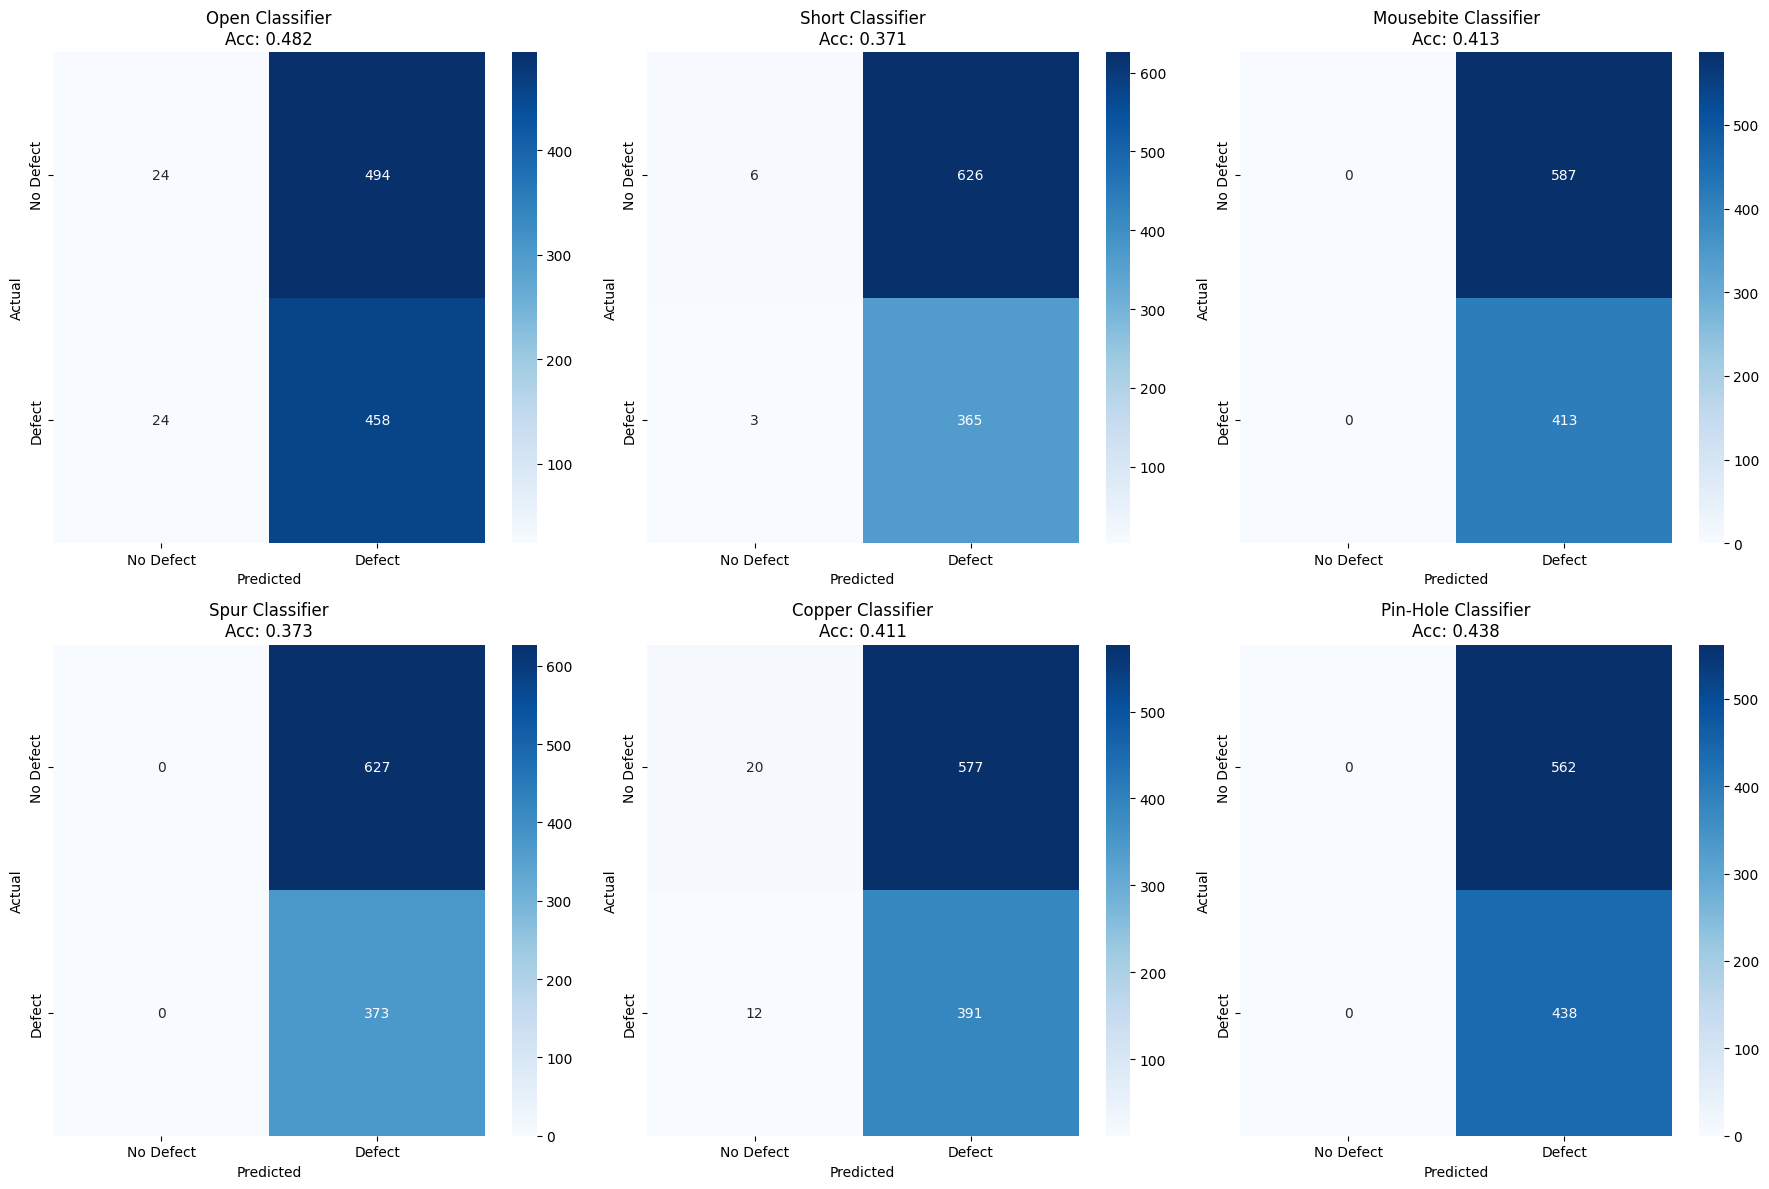

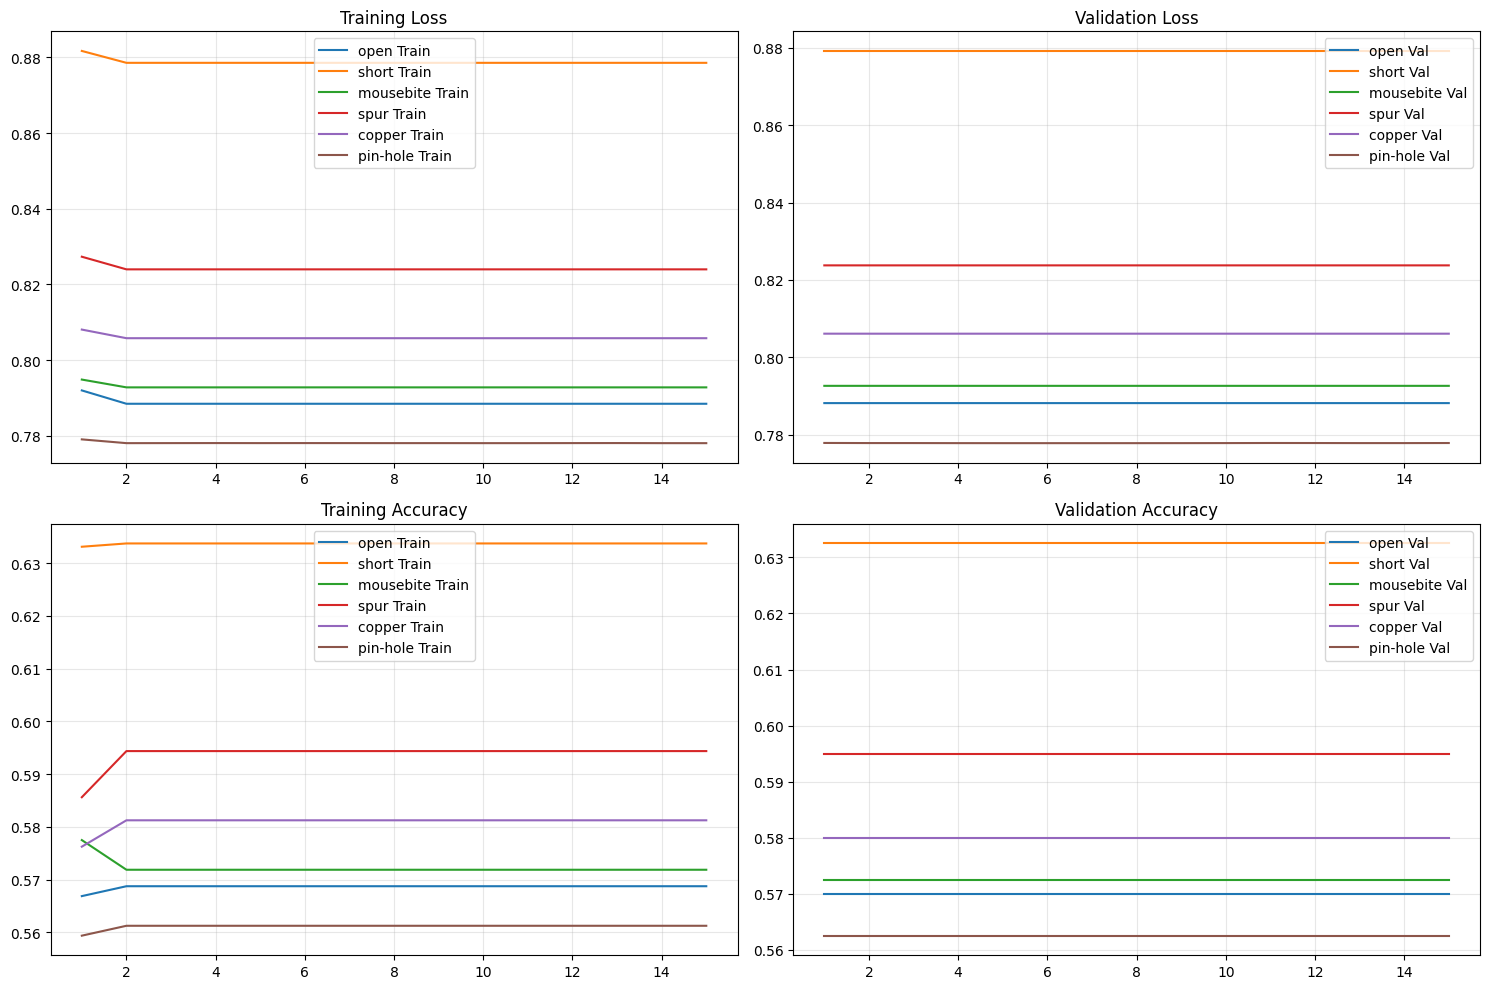


📊 ENSEMBLE PERFORMANCE SUMMARY
open        : Accuracy = 0.482, AUC = 0.487
short       : Accuracy = 0.371, AUC = 0.438
mousebite   : Accuracy = 0.413, AUC = 0.510
spur        : Accuracy = 0.373, AUC = 0.512
copper      : Accuracy = 0.411, AUC = 0.497
pin-hole    : Accuracy = 0.438, AUC = 0.520

Average Accuracy: 0.415
Best Performer: open
Worst Performer: short


In [ ]:
# Cell 10: Evaluation and Results
# ================================
# Evaluate ensemble
results = ensemble.evaluate_ensemble(binary_datasets)

# Visualize results
plot_ensemble_results(ensemble, results)

# Summary statistics
print(f"\n{'='*60}")
print("📊 ENSEMBLE PERFORMANCE SUMMARY")
print(f"{'='*60}")

overall_accs = []
for defect_type, result in results.items():
    acc = result['accuracy']
    auc = result['auc']
    overall_accs.append(acc)

    print(f"{defect_type:12}: Accuracy = {acc:.3f}", end="")
    if auc:
        print(f", AUC = {auc:.3f}")
    else:
        print()

print(f"\nAverage Accuracy: {np.mean(overall_accs):.3f}")
print(f"Best Performer: {max(results.keys(), key=lambda x: results[x]['accuracy'])}")
print(f"Worst Performer: {min(results.keys(), key=lambda x: results[x]['accuracy'])}")